In the previous notebook, I ended up with a dataframe with all necessary rows and clean columns: https://github.com/fractaldatalearning/Capstone2/blob/main/notebooks/preprocessing1b_get_usable_df.ipynb

Here, I'll create a column that indicates how many times any given item has been ordered by a user in the past. Then use that to calculate the percentage of past orders where a user has purchased any given item. 

My intuition is that cross-row calculations don't count as leakage and negatively impact modeling IF I'm adding data that has exclusively to do with past orders. If this logic turns out to be inappropriate, I can just come back and split the set into separate users (or into certain orders per user) and re-run any subsequent code. 

Once that row has been completed, I'll engineer columns for product keywords and do any other feature engineering that is possible prior to certain encoding and standardization that is better done as part of a modeling pipeline. 

In [31]:
import pandas as pd
import numpy as np
import os
from library.sb_utils import save_file

import random
import collections

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Audio
sound_file = './alert.wav'

In [2]:
df = pd.read_csv('../data/processed/users_all_rows_clean.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218232 entries, 0 to 218231
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                218232 non-null  int64  
 1   user_id                 218232 non-null  int64  
 2   order_by_user_sequence  218232 non-null  int64  
 3   order_dow               218232 non-null  int64  
 4   order_hour_of_day       218232 non-null  int64  
 5   days_since_prior_order  218232 non-null  float64
 6   add_to_cart_sequence    218232 non-null  int64  
 7   reordered               218232 non-null  int64  
 8   product_name            218232 non-null  object 
 9   aisle_name              218232 non-null  object 
 10  dept_name               218232 non-null  object 
dtypes: float64(1), int64(7), object(3)
memory usage: 18.3+ MB


In [3]:
# In order to group the dataframe and get a cumsum of purchases, I'll need a 'purchased' column

df['purchased'] = 0
df['purchased'] = df[df['add_to_cart_sequence']>0]['purchased'].replace(0,1)
df['purchased'] = df['purchased'].fillna(0)

df['purchased'].value_counts()

0.0    182154
1.0     36078
Name: purchased, dtype: int64

In [4]:
relevant_cols = df.loc[:,['user_id', 'order_by_user_sequence', 'purchased', 'product_name']]
grouped_df = relevant_cols.groupby(['user_id', 'product_name', 
                                    'order_by_user_sequence']).sum().groupby(
    level=[0,1]).cumsum().reset_index()
grouped_df.head()

,user_id,product_name,order_by_user_sequence,purchased
0,275,Arrowroot Starch/Flour,1,1.0
1,275,Arrowroot Starch/Flour,2,1.0
2,275,Arrowroot Starch/Flour,3,2.0
3,275,Arrowroot Starch/Flour,4,2.0
4,275,Arrowroot Starch/Flour,5,2.0


In [5]:
# Check to make sure the cumsum is just taken on each user's orders per product.
grouped_df[grouped_df['product_name']=='Arrowroot Starch/Flour']

,user_id,product_name,order_by_user_sequence,purchased
0,275,Arrowroot Starch/Flour,1,1.0
1,275,Arrowroot Starch/Flour,2,1.0
2,275,Arrowroot Starch/Flour,3,2.0
3,275,Arrowroot Starch/Flour,4,2.0
4,275,Arrowroot Starch/Flour,5,2.0
5,275,Arrowroot Starch/Flour,6,2.0
6,275,Arrowroot Starch/Flour,7,2.0
7,275,Arrowroot Starch/Flour,8,2.0
8,275,Arrowroot Starch/Flour,9,2.0
9,275,Arrowroot Starch/Flour,10,2.0


In [6]:
df[(df['user_id']==60433)&(df['product_name']=='Arrowroot Starch/Flour')]

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_sequence,reordered,product_name,aisle_name,dept_name,purchased
10145,1260603,60433,6,0,11,3.0,8,0,Arrowroot Starch/Flour,baking ingredients,pantry,1.0
10188,2516838,60433,15,6,8,29.0,3,1,Arrowroot Starch/Flour,baking ingredients,pantry,1.0
217638,1729088,60433,7,3,16,3.0,0,0,Arrowroot Starch/Flour,baking ingredients,pantry,0.0
217667,2927050,60433,8,0,10,4.0,0,0,Arrowroot Starch/Flour,baking ingredients,pantry,0.0
217701,3160109,60433,9,2,17,2.0,0,0,Arrowroot Starch/Flour,baking ingredients,pantry,0.0
217738,2994098,60433,10,4,13,2.0,0,0,Arrowroot Starch/Flour,baking ingredients,pantry,0.0
217775,800346,60433,11,5,13,22.0,0,0,Arrowroot Starch/Flour,baking ingredients,pantry,0.0
217811,1174101,60433,12,0,18,23.0,0,0,Arrowroot Starch/Flour,baking ingredients,pantry,0.0
217848,2126526,60433,13,0,16,28.0,0,0,Arrowroot Starch/Flour,baking ingredients,pantry,0.0
217884,319467,60433,14,5,19,5.0,0,0,Arrowroot Starch/Flour,baking ingredients,pantry,0.0


The 'purchased' column in the grouped_df does correctly show how many times an item has been purchased. With user 60433, they first purchased arrowroot starch on their 6th order. Then, the value goes up to 2 when they order it again in order 15. One problem is that the purchased column shows a '1' and a '2' in the rows where they first purchase and reorder the item. To show only how many times they've purchased something in the past, I'll need to subtract 1 from every item in the 'purchased' column where add_to_cart_sequence>0. But first, get values from grouped_df into the full df. 

In [7]:
df = df.merge(grouped_df, on=['user_id', 'product_name', 'order_by_user_sequence'])
df.head(2)

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_sequence,reordered,product_name,aisle_name,dept_name,purchased_x,purchased_y
0,1098729,275,1,4,18,-1.0,4,0,Organic Half & Half,cream,dairy eggs,1.0,1.0
1,1098729,275,1,4,18,-1.0,2,0,Organic Whole Milk,milk,dairy eggs,1.0,1.0


In [8]:
df[(df['user_id']==60433)&(df['product_name']=='Arrowroot Starch/Flour')]

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_sequence,reordered,product_name,aisle_name,dept_name,purchased_x,purchased_y
10145,1260603,60433,6,0,11,3.0,8,0,Arrowroot Starch/Flour,baking ingredients,pantry,1.0,1.0
10188,2516838,60433,15,6,8,29.0,3,1,Arrowroot Starch/Flour,baking ingredients,pantry,1.0,2.0
217638,1729088,60433,7,3,16,3.0,0,0,Arrowroot Starch/Flour,baking ingredients,pantry,0.0,1.0
217667,2927050,60433,8,0,10,4.0,0,0,Arrowroot Starch/Flour,baking ingredients,pantry,0.0,1.0
217701,3160109,60433,9,2,17,2.0,0,0,Arrowroot Starch/Flour,baking ingredients,pantry,0.0,1.0
217738,2994098,60433,10,4,13,2.0,0,0,Arrowroot Starch/Flour,baking ingredients,pantry,0.0,1.0
217775,800346,60433,11,5,13,22.0,0,0,Arrowroot Starch/Flour,baking ingredients,pantry,0.0,1.0
217811,1174101,60433,12,0,18,23.0,0,0,Arrowroot Starch/Flour,baking ingredients,pantry,0.0,1.0
217848,2126526,60433,13,0,16,28.0,0,0,Arrowroot Starch/Flour,baking ingredients,pantry,0.0,1.0
217884,319467,60433,14,5,19,5.0,0,0,Arrowroot Starch/Flour,baking ingredients,pantry,0.0,1.0


In [9]:
# The merge succeeded. Work with purchased_y column to make sure it only shows past purchases.
df.loc[df['add_to_cart_sequence']>0, 'purchased_y'] -= 1
df[(df['user_id']==60433)&(df['product_name']=='Arrowroot Starch/Flour')]

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_sequence,reordered,product_name,aisle_name,dept_name,purchased_x,purchased_y
10145,1260603,60433,6,0,11,3.0,8,0,Arrowroot Starch/Flour,baking ingredients,pantry,1.0,0.0
10188,2516838,60433,15,6,8,29.0,3,1,Arrowroot Starch/Flour,baking ingredients,pantry,1.0,1.0
217638,1729088,60433,7,3,16,3.0,0,0,Arrowroot Starch/Flour,baking ingredients,pantry,0.0,1.0
217667,2927050,60433,8,0,10,4.0,0,0,Arrowroot Starch/Flour,baking ingredients,pantry,0.0,1.0
217701,3160109,60433,9,2,17,2.0,0,0,Arrowroot Starch/Flour,baking ingredients,pantry,0.0,1.0
217738,2994098,60433,10,4,13,2.0,0,0,Arrowroot Starch/Flour,baking ingredients,pantry,0.0,1.0
217775,800346,60433,11,5,13,22.0,0,0,Arrowroot Starch/Flour,baking ingredients,pantry,0.0,1.0
217811,1174101,60433,12,0,18,23.0,0,0,Arrowroot Starch/Flour,baking ingredients,pantry,0.0,1.0
217848,2126526,60433,13,0,16,28.0,0,0,Arrowroot Starch/Flour,baking ingredients,pantry,0.0,1.0
217884,319467,60433,14,5,19,5.0,0,0,Arrowroot Starch/Flour,baking ingredients,pantry,0.0,1.0


In [10]:
# The purchases_y column now contains the values I want. Clean this up.
df = df.drop(columns='purchased_x')
df = df.rename(columns={'purchased_y':'prior_purchases'})
df['prior_purchases'] = df['prior_purchases'].astype('int')
df.head(2)

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_sequence,reordered,product_name,aisle_name,dept_name,prior_purchases
0,1098729,275,1,4,18,-1.0,4,0,Organic Half & Half,cream,dairy eggs,0
1,1098729,275,1,4,18,-1.0,2,0,Organic Whole Milk,milk,dairy eggs,0


In [11]:
# It could be equally useful to know not just the count of prior purchases but the percent of 
# prior purchases in which an item was ordered. Create this column.
df['purchased_percent_prior'] = df['prior_purchases'] / df['order_by_user_sequence']
df['purchased_percent_prior'].value_counts()

0.000000    14844
0.166667     6203
0.200000     6138
0.250000     6015
0.142857     5984
            ...  
0.967742        1
0.968750        1
0.969697        1
0.970588        1
0.490196        1
Name: purchased_percent_prior, Length: 1548, dtype: int64

In [12]:
df.sample(15)

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_sequence,reordered,product_name,aisle_name,dept_name,prior_purchases,purchased_percent_prior
111376,1663023,137071,9,0,13,8.0,0,0,Natural Sharp Cheddar Sliced Cheese,packaged cheese,dairy eggs,1,0.111111
109324,1715860,91820,63,5,11,2.0,0,0,Plain Almond Milk Yogurt,milk,dairy eggs,21,0.333333
170874,954393,121224,59,6,19,5.0,0,0,Enriched Parboiled Long Grain Rice Original,grains rice dried goods,dry goods pasta,1,0.016949
196371,2101799,97345,17,1,14,13.0,0,0,Flax Plus Hot Oatmeal,hot cereal pancake mixes,breakfast,1,0.058824
104464,832666,186868,15,4,21,5.0,0,0,Organic Vanilla Extract,baking ingredients,pantry,1,0.066667
171504,1273620,121224,68,1,15,4.0,0,0,Organic Classic Saltine Crackers,crackers,snacks,2,0.029412
196986,1968629,97345,20,3,17,2.0,0,0,Organic Chicken Pot Pie,frozen meals,frozen,1,0.050000
206349,115996,80522,19,3,12,5.0,0,0,"Snacking Cheese, Fresh Mozzarella",specialty cheeses,dairy eggs,2,0.105263
12523,2664876,76347,23,5,12,3.0,4,0,Lavender Floral & Mint Natural Dish Liquid,dish detergents,household,0,0.000000
114779,27787,192605,38,5,14,8.0,0,0,Fridge and Freezer Baking Soda Pack,baking ingredients,pantry,1,0.026316


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 218232 entries, 0 to 218231
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   order_id                 218232 non-null  int64  
 1   user_id                  218232 non-null  int64  
 2   order_by_user_sequence   218232 non-null  int64  
 3   order_dow                218232 non-null  int64  
 4   order_hour_of_day        218232 non-null  int64  
 5   days_since_prior_order   218232 non-null  float64
 6   add_to_cart_sequence     218232 non-null  int64  
 7   reordered                218232 non-null  int64  
 8   product_name             218232 non-null  object 
 9   aisle_name               218232 non-null  object 
 10  dept_name                218232 non-null  object 
 11  prior_purchases          218232 non-null  int64  
 12  purchased_percent_prior  218232 non-null  float64
dtypes: float64(2), int64(8), object(3)
memory usage: 23.3+ MB


In [14]:
df.describe()

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_sequence,reordered,prior_purchases,purchased_percent_prior
count,2.182320e+05,218232.000000,218232.000000,218232.000000,218232.000000,218232.000000,218232.000000,218232.000000,218232.000000,218232.000000
mean,1.712300e+06,107939.489639,23.589785,2.837228,13.326345,9.344354,1.353628,0.097300,2.317002,0.133054
std,9.827404e+05,62494.565509,18.703673,2.031442,4.222223,8.254226,4.100279,0.296367,3.316889,0.149217
min,1.083000e+03,275.000000,1.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,8.705320e+05,52352.000000,10.000000,1.000000,10.000000,4.000000,0.000000,0.000000,1.000000,0.038462
50%,1.687420e+06,97345.000000,19.000000,3.000000,13.000000,7.000000,0.000000,0.000000,1.000000,0.076923
75%,2.577019e+06,161549.000000,31.000000,5.000000,16.000000,12.000000,0.000000,0.000000,2.000000,0.166667
max,3.418532e+06,205040.000000,100.000000,6.000000,23.000000,30.000000,47.000000,1.000000,67.000000,0.980000


This dataset now has all the necessary rows and columns in order to use it for making predictions. Every order by ever user contains a row for every item they have ever purchased, and the prior_purchases column contains the number of times a user has bought any given item *in the past*. This could be ready for encoding and modeling. 

First, though, I'll do some feature engineering with the product names to pull out potential keywords that could improve model performance. 

In [15]:
# Engineer columns for product keywords. # Start with getting words that appear in product 
# names but aren't already covered by aisle and department classifications. 

all_prod_words = set(df['product_name'].tolist())
all_prod_words = [i.split() for i in all_prod_words]
all_prod_words = [i for sublist in all_prod_words for i in sublist]

aisle_words = set(df['aisle_name'].tolist())
aisle_words = [i.split() for i in aisle_words]
aisle_words = [i for sublist in aisle_words for i in sublist]
aisle_words = list(set(aisle_words))

dept_words = set(df['dept_name'].tolist())
dept_words = [i.split() for i in dept_words]
dept_words = [i for sublist in dept_words for i in sublist]
dept_words = list(set(dept_words))

all_prod_unique_words = [word for word in all_prod_words if word not in aisle_words]
all_prod_unique_words = [word for word in all_prod_words if word not in dept_words]

counts = collections.Counter(all_prod_words)
counts.most_common(50)

[('Organic', 1193),
 ('&', 547),
 ('Cheese', 329),
 ('Free', 278),
 ('Yogurt', 218),
 ('Chocolate', 218),
 ('Original', 217),
 ('Milk', 200),
 ('Whole', 192),
 ('Chicken', 189),
 ('Cream', 165),
 ('Natural', 160),
 ('Sauce', 148),
 ('Butter', 145),
 ('Rice', 144),
 ('White', 135),
 ('with', 132),
 ('Vanilla', 130),
 ('Juice', 128),
 ('Water', 127),
 ('Cheddar', 123),
 ('Gluten', 123),
 ('Tea', 121),
 ('Baby', 121),
 ('Coconut', 119),
 ('Bread', 118),
 ('Chips', 116),
 ('100%', 114),
 ('Salt', 114),
 ('Mix', 113),
 ('Fresh', 111),
 ('Fruit', 110),
 ('Fat', 109),
 ('Sweet', 108),
 ('Almond', 107),
 ('Oil', 100),
 ('Apple', 96),
 ('Roasted', 92),
 ('Corn', 92),
 ('Bar', 91),
 ('Red', 90),
 ('Greek', 90),
 ('Strawberry', 87),
 ('Green', 87),
 ('Crackers', 86),
 ('Pasta', 84),
 ('Potato', 84),
 ('Brown', 83),
 ('Honey', 83),
 ('Grain', 83)]

Now, if high-frequency words appear in products across many different departments, it could  sense to give them their own column. Explore words with  values over 100. "Fresh" seems like a meaningful feature, but none of the words that appear under 100 times seem to be as meaningul as product types. Do remove obviously useless words like '&'.

In [16]:
potential_keywords = ['Organic', 'Cheese', 'Free', 'Yogurt', 'Chocolate', 'Original', 'Milk', 
                      'Whole', 'Chicken', 'Cream', 'Natural', 'Sauce', 'Butter', 'Rice', 'White',
                      'Vanilla', 'Juice', 'Water', 'Gluten', 'Cheddar', 'Tea', 'Baby', 'Coconut',
                      'Bread', 'Chips', 'Salt', 'Mix', 'Fresh', 'Fruit', 'Fat', 'Sweet', 
                      'Almond', 'Oil']
potential_keywords.sort()

for k in potential_keywords:
    print(k, ': ', len(df[df['product_name'].str.contains(k)]['dept_name'].unique()))

Almond :  11
Baby :  12
Bread :  6
Butter :  13
Cheddar :  8
Cheese :  10
Chicken :  12
Chips :  5
Chocolate :  8
Coconut :  12
Cream :  12
Fat :  11
Free :  19
Fresh :  17
Fruit :  14
Gluten :  14
Juice :  5
Milk :  10
Mix :  15
Natural :  16
Oil :  12
Organic :  19
Original :  19
Rice :  14
Salt :  8
Sauce :  7
Sweet :  18
Tea :  6
Vanilla :  12
Water :  8
White :  16
Whole :  16
Yogurt :  7


To me, it would make sense to put the cutoff at words that appear in over 13 departments: Free, Fresh, Mix, Natural, Organic, Original, Sweet, White, Whole, Rice, Fruit, Gluten. 

In [17]:
# Start a column for each keyword.

keywords = ['free', 'fresh', 'mix', 'natural', 'organic', 'original', 'sweet', 'white', 'whole',
           'rice', 'fruit', 'gluten']

df[keywords] = 0
df.columns

Index(['order_id', 'user_id', 'order_by_user_sequence', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'add_to_cart_sequence',
       'reordered', 'product_name', 'aisle_name', 'dept_name',
       'prior_purchases', 'purchased_percent_prior', 'free', 'fresh', 'mix',
       'natural', 'organic', 'original', 'sweet', 'white', 'whole', 'rice',
       'fruit', 'gluten'],
      dtype='object')

In [18]:
# Fill each column with a 1 where the word appears in the product name.

for k in keywords:
    df[k] = df[k].mask(df['product_name'].str.contains(k.title()), 1)

df['free'].value_counts()

0    211446
1      6786
Name: free, dtype: int64

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 218232 entries, 0 to 218231
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   order_id                 218232 non-null  int64  
 1   user_id                  218232 non-null  int64  
 2   order_by_user_sequence   218232 non-null  int64  
 3   order_dow                218232 non-null  int64  
 4   order_hour_of_day        218232 non-null  int64  
 5   days_since_prior_order   218232 non-null  float64
 6   add_to_cart_sequence     218232 non-null  int64  
 7   reordered                218232 non-null  int64  
 8   product_name             218232 non-null  object 
 9   aisle_name               218232 non-null  object 
 10  dept_name                218232 non-null  object 
 11  prior_purchases          218232 non-null  int64  
 12  purchased_percent_prior  218232 non-null  float64
 13  free                     218232 non-null  int64  
 14  fres

In [20]:
# Product keyword columns got created successfully. Now, Look into departments to see which
# products belong to 'missing' and 'other' columns. Consider if reclassification makes sense.

print(df[df['dept_name']=='missing']['product_name'].unique())
print(df[df['dept_name']=='other']['product_name'].unique())

['Organic Lime Bag' 'Satsuma' 'Cayenne Cleanse Kombucha'
 'Organic Sweet Potato (Yam)' 'Organic Celery Bunch' 'Baby Broccoli'
 'Raise The Roots Kombucha' 'Organic Uncured Beef Hot Dog'
 'Peanut Butter Ice Cream Cup' 'Uncured Beef Hot Dog'
 'Gluten-Free Cornbread Mix' 'Yellow Onion Bag' 'Thai Chile Pepper'
 'Noodle Chicken' 'Organic Fennel Bulb' 'Lndbrg Wht Jasm Rice 8 Z'
 'Constellation Medley Tomato Pack'
 'Organic Black Bean Beet Banana Baby Food'
 'Organic Whole Milk Washington Black Cherry Yogurt'
 'Organic Mango Yogurt'
 'Soy & Dairy Free Plain Unsweetened Almond Milk Yogurt'
 'Almond Milk Vanilla Yogurt' 'Organic English Seedless Cucumber'
 'Banana Nonfat Yogurt' 'Organic Riced Cauliflower' 'Hachiya Persimmon'
 'Strained Non-Fat Strawberry Icelandic Style Skyr Yogurt'
 'Organic Plain Unsweetened Nondairy Cashew Yogurt'
 'Lime Grain-Free Tortilla Chips' 'Organic Chickpea Fusilli Pasta'
 'Fresh Organic Carrots' 'Cloud 9 Pancake Mix'
 'Steamables Russet Potatoes']
['Coconut Flour' '

In [21]:
# These products seemingly could easily be reclassified into other existing departments;
# it's hard to know how much modeling would be improved if all items are correctly classified
# but it doesn't hurt to give them new department names. Also, which aisles are these in?
print(df[df['dept_name']=='missing']['aisle_name'].unique())
print(df[df['dept_name']=='other']['aisle_name'].unique())

['missing']
['other']


In [22]:
# Choose a new aisle/department pair for at least products in 'missing.' And 'other' if there's 
# some obvious fit. It's easiest to choose a department first, then each department's items 
# can be placed in the correct aisle. 

df['dept_name'].sort_values().unique()

array(['alcohol', 'babies', 'bakery', 'beverages', 'breakfast', 'bulk',
       'canned goods', 'dairy eggs', 'deli', 'dry goods pasta', 'frozen',
       'household', 'international', 'meat seafood', 'missing', 'other',
       'pantry', 'personal care', 'pets', 'produce', 'snacks'],
      dtype=object)

In [23]:
correct_dept = {'Organic Lime Bag':'produce', 'Satsuma':'produce', 'Cayenne Cleanse Kombucha':
               'beverages', 'Organic Sweet Potato (Yam)':'produce', 'Organic Celery Bunch':
                'produce', 'Raise The Roots Kombucha':'beverages', 
                'Organic Uncured Beef Hot Dog':'meat seafood', 'Peanut Butter Ice Cream Cup':
               'frozen', 'Uncured Beef Hot Dog':'meat seafood', 'Gluten-Free Cornbread Mix':
               'pantry', 'Yellow Onion Bag':'produce', 'Thai Chile Pepper':'produce',
               'Noodle Chicken':'canned goods', 'Organic Fennel Bulb':'produce', 
                'Lndbrg Wht Jasm Rice 8 Z':'dry goods pasta', 'Constellation Medley Tomato Pack':
               'produce', 'Organic Black Bean Beet Banana Baby Food':'babies', 
               'Organic Whole Milk Washington Black Cherry Yogurt':'dairy eggs', 
                'Organic Mango Yogurt':'dairy eggs', 
                'Soy & Dairy Free Plain Unsweetened Almond Milk Yogurt':'dairy eggs',
               'Almond Milk Vanilla Yogurt':'dairy eggs', 'Organic English Seedless Cucumber':
               'produce', 'Banana Nonfat Yogurt':'dairy eggs', 'Organic Riced Cauliflower':
               'produce', 'Hachiya Persimmon':'produce', 
                'Strained Non-Fat Strawberry Icelandic Style Skyr Yogurt':'dairy eggs',
               'Organic Plain Unsweetened Nondairy Cashew Yogurt':'dairy eggs', 
                'Lime Grain-Free Tortilla Chips':'snacks', 'Organic Chickpea Fusilli Pasta':
               'dry goods pasta', 'Fresh Organic Carrots':'produce', 'Cloud 9 Pancake Mix':
               'pantry', 'Steamables Russet Potatoes':'produce', 'Coconut Flour':'pantry',
               'Spicy Salmon Roll':'deli', 'Natural Relief Baby Teething Tablets':'babies',
               '93/7 Ground Beef':'meat seafood', 'Rescue Remedy':'personal care',
               'Sunflower Seeds':'bulk', 'Tahini Sesame Paste':'international', 
               'Organic Supreme Fruit & Nut Mix':'bulk', 'Organic Eucalyptus Oil':
                'personal care', 'Baiocchi':'snacks', 'Coconut Almond Granola':'breakfast',
               'Sweetened Lime Juice':'beverages', 'Beef Chuck Roast':'meat seafood',
               'Walnuts':'bulk', 'Strike On Box Matches':'household', 
                'Coconut Lime Frozen Pop Dairy Free Gluten Free':'frozen', 
               'Maximum Strength Original Diaper Rash Ointment':'babies', 
                'Liquid Teething Relief':'babies', 'Spring Water Refill Liquid Hand Soap':
                'personal care', 'Organic Flax Seed':'bulk', 'Black Chia Seeds':'pantry',
               'Roasted Unsalted Almonds':'bulk', 'Boneless Beef Chuck Steak':'meat seafood',
               'Rainbow Roll':'deli', 'Baby Broccoli':'produce'}

for key, value in correct_dept.items():
    df.loc[df['product_name']==key, 'dept_name'] = value

df[df['dept_name'].isin(['missing', 'other'])]

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_sequence,reordered,product_name,aisle_name,...,mix,natural,organic,original,sweet,white,whole,rice,fruit,gluten


In [24]:
df['dept_name'].unique()

array(['dairy eggs', 'frozen', 'produce', 'pantry', 'dry goods pasta',
       'snacks', 'international', 'canned goods', 'meat seafood',
       'bakery', 'deli', 'beverages', 'household', 'breakfast',
       'personal care', 'pets', 'alcohol', 'babies', 'bulk'], dtype=object)

In [25]:
df[df['dept_name']=='bulk']['aisle_name'].unique()

array(['bulk grains rice dried goods', 'bulk dried fruits vegetables',
       'other'], dtype=object)

In [26]:
# missing and other department names have been eliminated. Now, find correct aisles.

correct_aisle = {'Organic Lime Bag':'fresh fruits', 'Satsuma':'fresh fruit', 
                 'Cayenne Cleanse Kombucha':
               'refrigerated', 'Organic Sweet Potato (Yam)':'fresh vegetables', 'Organic Celery Bunch':
                'fresh vegetables', 'Raise The Roots Kombucha':'refrigerated', 
                'Organic Uncured Beef Hot Dog':'hot dogs bacon sausage', 'Peanut Butter Ice Cream Cup':
               'frozen dessert', 'Uncured Beef Hot Dog':'hot dogs bacon sausage', 'Gluten-Free Cornbread Mix':
               'doughs gelatins bake mixes', 'Yellow Onion Bag':'fresh vegetables', 'Thai Chile Pepper':'fresh vegetables',
               'Noodle Chicken':'soup broth bouillon', 'Organic Fennel Bulb':'fresh vegetables', 
                'Lndbrg Wht Jasm Rice 8 Z':'grains rice dried goods', 'Constellation Medley Tomato Pack':
               'packaged vegetables fruits', 'Organic Black Bean Beet Banana Baby Food':'baby food formula', 
               'Organic Whole Milk Washington Black Cherry Yogurt':'yogurt', 
                'Organic Mango Yogurt':'yogurt', 
                'Soy & Dairy Free Plain Unsweetened Almond Milk Yogurt':'yogurt',
               'Almond Milk Vanilla Yogurt':'yogurt', 'Organic English Seedless Cucumber':
               'fresh vegetables', 'Banana Nonfat Yogurt':'yogurt', 'Organic Riced Cauliflower':
               'packaged vegetables fruits', 'Hachiya Persimmon':'fresh fruits', 
                'Strained Non-Fat Strawberry Icelandic Style Skyr Yogurt':'yogurt',
               'Organic Plain Unsweetened Nondairy Cashew Yogurt':'yogurt', 
                'Lime Grain-Free Tortilla Chips':'chips pretzels', 'Organic Chickpea Fusilli Pasta':
               'dry pasta', 'Fresh Organic Carrots':'fresh vegetables', 
                 'Cloud 9 Pancake Mix':'doughs gelatins bake mixes', 
                 'Steamables Russet Potatoes':'packaged vegetables fruits', 
                 'Coconut Flour':'baking ingredients',
               'Spicy Salmon Roll':'prepared meals', 'Natural Relief Baby Teething Tablets':'baby accessories',
               '93/7 Ground Beef':'packaged meat', 'Rescue Remedy':'vitamins supplements',
               'Sunflower Seeds':'bulk grains rice dried goods', 'Tahini Sesame Paste':'asian foods', 
               'Organic Supreme Fruit & Nut Mix':'bulk grains rice dried goods', 'Organic Eucalyptus Oil':
                'personal care', 'Baiocchi':'cookies cakes', 'Coconut Almond Granola':'granola',
               'Sweetened Lime Juice':'refrigerated', 'Beef Chuck Roast':'meat counter',
               'Walnuts':'bulk grains rice dried goods', 'Strike On Box Matches':'more household', 
                'Coconut Lime Frozen Pop Dairy Free Gluten Free':'frozen dessert', 
               'Maximum Strength Original Diaper Rash Ointment':'baby bath body care', 
                'Liquid Teething Relief':'baby accessories', 'Spring Water Refill Liquid Hand Soap':
                'soap', 'Organic Flax Seed':'bulk grains rice dried goods', 'Black Chia Seeds':'baking ingredients',
               'Roasted Unsalted Almonds':'bulk grains rice dried goods', 'Boneless Beef Chuck Steak':'meat counter',
               'Rainbow Roll':'prepared meals', 'Baby Broccoli':'fresh vegetables'}

for key, value in correct_aisle.items():
    df.loc[df['product_name']==key, 'aisle_name'] = value
    
df[df['aisle_name'].isin(['missing', 'other'])]

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_sequence,reordered,product_name,aisle_name,...,mix,natural,organic,original,sweet,white,whole,rice,fruit,gluten


In [27]:
# All products fairly well categorized now. As a last step for this notebook, change format of 
# dow, hour columns so the computer will be more likely to interpret these values as circular. 

df['dow_sin'] = np.sin(df['order_dow'] * (2 * np.pi / 7))
df['dow_cos'] = np.cos(df['order_dow'] * (2 * np.pi / 7))
df = df.drop(columns='order_dow')

df['hour_sin'] = np.sin(df['order_hour_of_day'] * (2 * np.pi / 24))
df['hour_cos'] = np.cos(df['order_hour_of_day'] * (2 * np.pi / 24))
df = df.drop(columns='order_hour_of_day')

print(df['dow_sin'].unique())
print(df['dow_cos'].unique())
print(df['hour_sin'].unique())
print(df['hour_cos'].unique()) 

[-0.43388374  0.97492791 -0.97492791  0.78183148  0.          0.43388374
 -0.78183148]
[-0.90096887 -0.22252093 -0.22252093  0.6234898   1.         -0.90096887
  0.6234898 ]
[-1.00000000e+00 -7.07106781e-01 -2.58819045e-01  2.58819045e-01
  1.22464680e-16 -5.00000000e-01 -9.65925826e-01 -8.66025404e-01
 -8.66025404e-01  5.00000000e-01  8.66025404e-01 -7.07106781e-01
  7.07106781e-01 -9.65925826e-01 -5.00000000e-01  9.65925826e-01
  1.00000000e+00  9.65925826e-01  8.66025404e-01 -2.58819045e-01
  0.00000000e+00  2.58819045e-01  7.07106781e-01  5.00000000e-01]
[-1.83697020e-16 -7.07106781e-01 -9.65925826e-01 -9.65925826e-01
 -1.00000000e+00 -8.66025404e-01 -2.58819045e-01 -5.00000000e-01
  5.00000000e-01 -8.66025404e-01 -5.00000000e-01  7.07106781e-01
 -7.07106781e-01  2.58819045e-01  8.66025404e-01 -2.58819045e-01
  6.12323400e-17  2.58819045e-01  5.00000000e-01  9.65925826e-01
  1.00000000e+00  9.65925826e-01  7.07106781e-01  8.66025404e-01]


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 218232 entries, 0 to 218231
Data columns (total 27 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   order_id                 218232 non-null  int64  
 1   user_id                  218232 non-null  int64  
 2   order_by_user_sequence   218232 non-null  int64  
 3   days_since_prior_order   218232 non-null  float64
 4   add_to_cart_sequence     218232 non-null  int64  
 5   reordered                218232 non-null  int64  
 6   product_name             218232 non-null  object 
 7   aisle_name               218232 non-null  object 
 8   dept_name                218232 non-null  object 
 9   prior_purchases          218232 non-null  int64  
 10  purchased_percent_prior  218232 non-null  float64
 11  free                     218232 non-null  int64  
 12  fresh                    218232 non-null  int64  
 13  mix                      218232 non-null  int64  
 14  natu

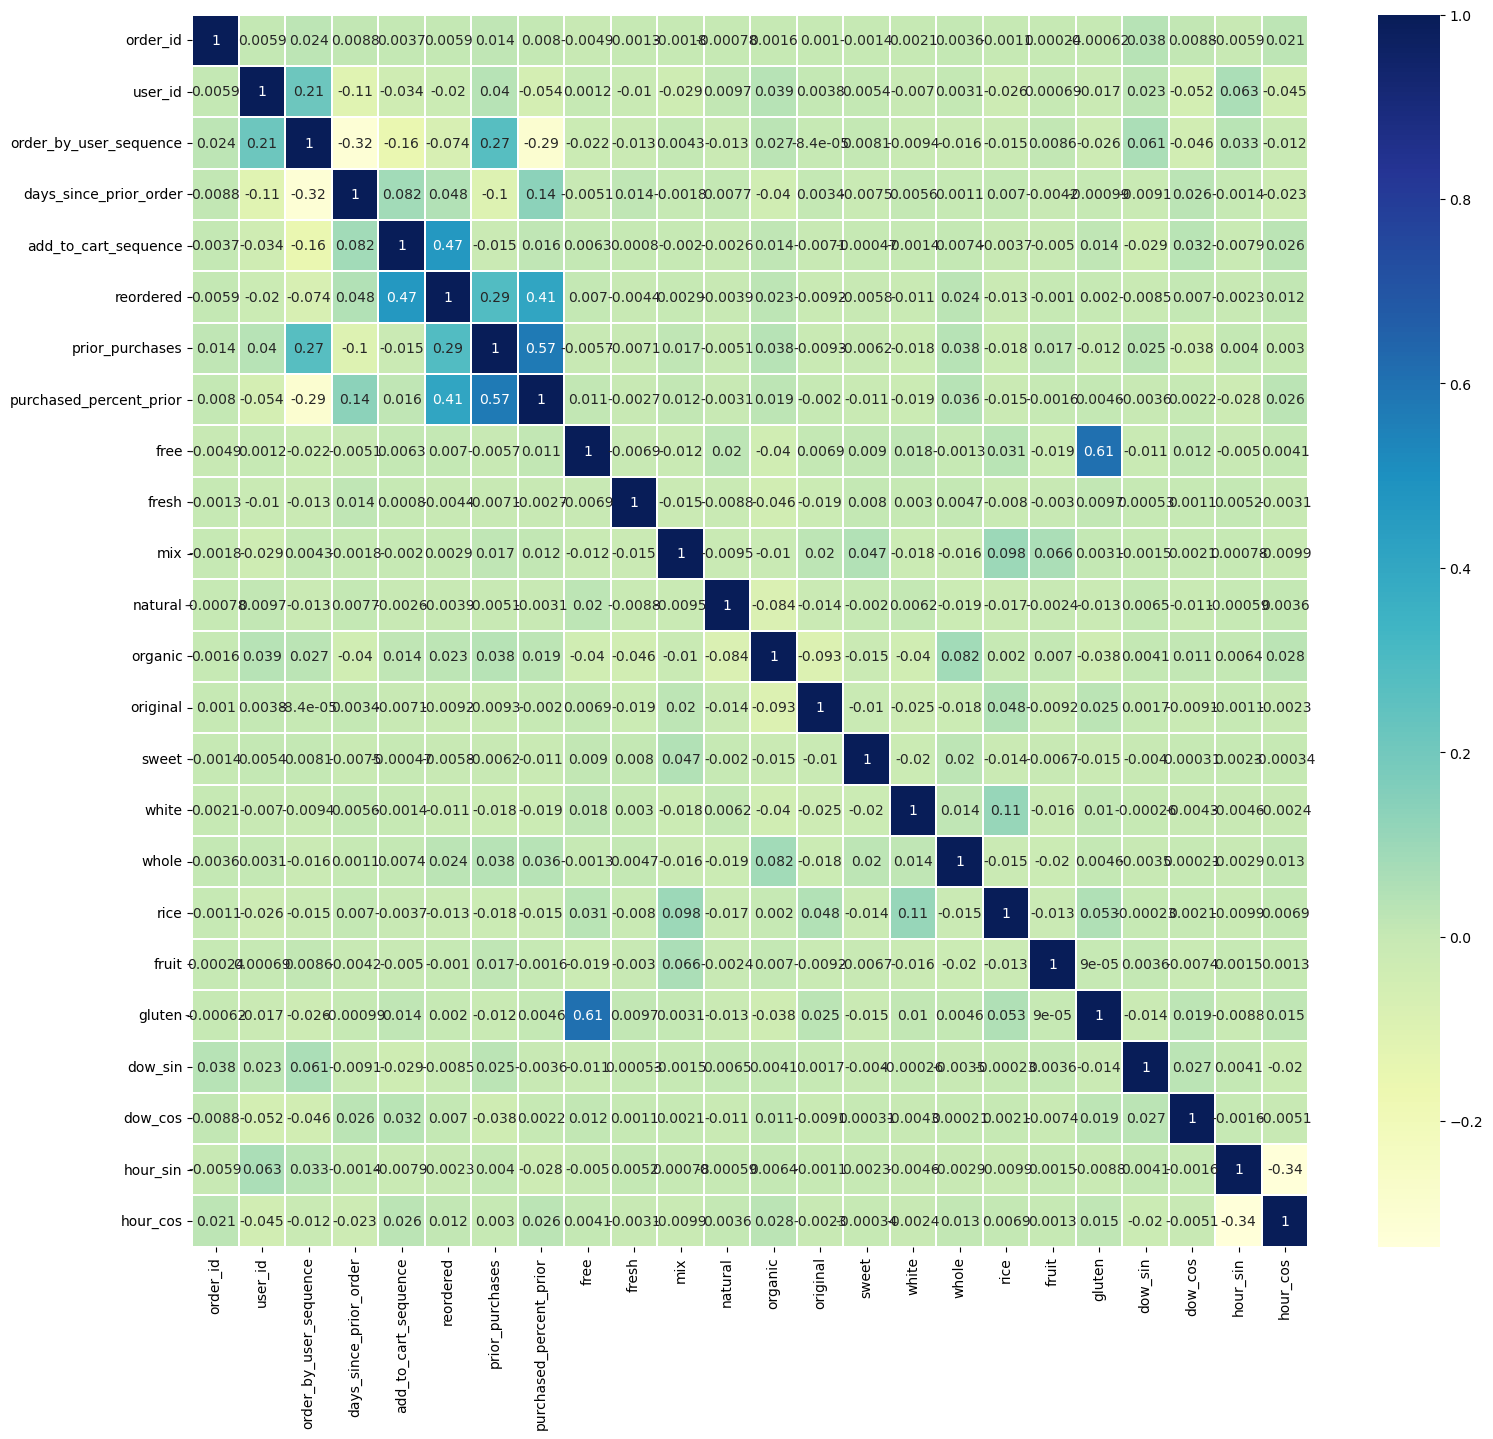

In [33]:
# Do any of these new columns have a higher correlation to the target variable than columns 
# did in the past?
plt.figure(figsize=(18,16))
sns.heatmap(df.corr(), linewidths=.1, cmap="YlGnBu", annot=True)
plt.yticks(rotation=0);

Predictably, the prior_puchases column has a higher correlation with 'reordered' than previously existing variables. The purchased_percent_prior has an even higher correlation, almost as high as 'add_to_cart_sequence,' which is actually another dependent variable and extremely predictive of reorders given that 100% of reorders occur where add_to_cart_sequence>0. So purchased_percent_prior, despite not leaking data about the current order's actual target variable, is a strong predictor and will be very useful in modeling. 

Can't do the rest of the encoding or normalization until I have a train/test split and pipeline for it. Save work done so far as new csv file and pick up in next notebook preprocessing3: https://github.com/fractaldatalearning/Capstone2/blob/main/notebooks/preprocessing3_encoding.ipynb

In [29]:
features_engineered = df
datapath = '../data/processed'
save_file(features_engineered, 'features_engineered.csv', datapath)

A file already exists with this name.

Do you want to overwrite? (Y/N)Y
Writing file.  "../data/processed/features_engineered.csv"
